# Read a roast file

Did my first roast.  File is `data/roastomatic_202050224T181213.txt`

There's a 13 line header where the serial monitor is attaching.  I don't know whether that's consistent across runs or not.  Then, the board reset when I hit the drop, which is fine for now, but I need to debug.  So only the first 2700 or so lines are valid.  It's sampled a 4Hz.

In [510]:
# standard packages
import bisect


# third-party packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d



# Read the data
file = '../data/roastomatic_20250224T181213.txt'
names = [
    "roast_time",
    "total_time",
    "state",
    "fan_value",
    "heat_value",
    "bean_temp_f", 
    "intake_temp_f",
    "weight",
    "drop_percent"
]

df = pd.read_csv(file,names=names,skiprows=14,nrows=(2710-14))

# Integer representing milliseconds
for times in ["total_time", "roast_time"]:
    df[times] = pd.to_timedelta(df[times],unit='milliseconds').dt.total_seconds()
df

,roast_time,total_time,state,fan_value,heat_value,bean_temp_f,intake_temp_f,weight,drop_percent
0,0.000,0.788,heat,0,0,63.95,64.85,373639.00,0.00
1,0.000,1.085,heat,0,0,63.95,64.85,373738.00,0.00
2,0.000,1.357,heat,0,0,63.05,64.40,373745.00,0.00
3,0.000,1.655,heat,0,0,63.50,64.85,373804.00,0.00
4,0.000,1.927,heat,0,0,63.50,64.85,373705.00,0.00
...,...,...,...,...,...,...,...,...,...
2691,560.461,766.464,cook,4095,4095,369.95,297.05,85.12,5.52
2692,560.755,766.758,cook,4095,4095,369.95,296.60,86.74,3.73
2693,561.027,767.030,cook,4095,4095,370.40,297.50,83.73,7.07
2694,561.322,767.325,cook,4095,4095,370.40,297.50,81.70,9.33


## Roast Profile
First thing is to plot everything during the cook state vs roast_time


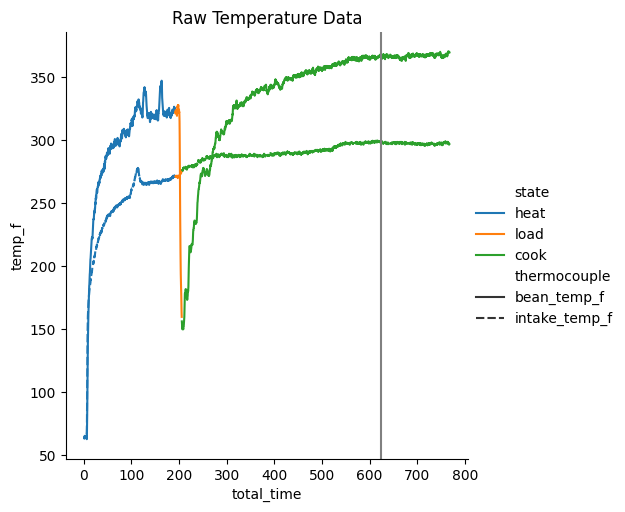

In [511]:

def plot_roast_profile(df):
    df_melted = df.melt(id_vars=['total_time','state'], value_vars=['bean_temp_f', 'intake_temp_f'], var_name='thermocouple', value_name='temp_f')
    sns.relplot(data=df_melted, x="total_time", y="temp_f", hue="state", style="thermocouple", kind="line")
    plt.axvline(x=195+7*60+9, color='gray')
    plt.title("Raw Temperature Data")
plot_roast_profile(df)
plt.show()

We can observer the drop in the bean thermocouple when the beans are loaded.  There's a slight rise in the intake temperature over the course of the roast, suggesting that either I didn't wait long enough in the preheat or the metal cup is radiating back into the housing.  Probably a combination of both.  Either way, I need to let the thing preheat longer.

The peak at 150 seconds is due to me turning the fan down for a few seconds to see if I could coax the temperature higher.

The other thing to notice is the noise characteristics of the bean temperature versus the intake temperatures  This is due to the increases airflow and the friction of the beans moving against the thermocouple. Interestingly I don't think the bean's contribution to noise are that much greater than the air by itself.  We don't particularly care about bean temperature prior to the beans going in.  We'd like to simply correct the bean temperature to be the same as the intake temperature.  

### Data Cleanup

The sampling interval is irregular on the order of a few milliseconds.  We will be doing an FFT on the data which requires regular sampling intervals.  Nominally the Serial output is set to every 250ms, so we will interpolate to that sample rate

In [512]:

# Interpolate the data to a regular grid
sampling_frequency_hz = 4
regular_total_time = np.arange(np.ceil(min(df["total_time"])), np.floor(max(df["total_time"])), 1/sampling_frequency_hz)
df_regular = pd.DataFrame(regular_total_time, columns=['total_time'])

# to fill categorical variables find the category of the closest time.
closest_index = [(df['total_time'] - i).abs().idxmin() for i in regular_total_time]
df_regular['state'] = df.loc[closest_index, 'state'].values
for name in df.columns.drop(['total_time', 'state']):
    interpolator = interp1d(df["total_time"], df[name], kind='linear')
    df_regular[name] = interpolator(regular_total_time)
df_regular

,total_time,state,roast_time,fan_value,heat_value,bean_temp_f,intake_temp_f,weight,drop_percent
0,1.00,heat,0.000,0.0,0.0,63.950000,64.850000,373709.666667,0.000000
1,1.25,heat,0.000,0.0,0.0,63.404044,64.577022,373742.246324,0.000000
2,1.50,heat,0.000,0.0,0.0,63.265940,64.615940,373773.312081,0.000000
3,1.75,heat,0.000,0.0,0.0,63.500000,64.850000,373769.422794,0.000000
4,2.00,heat,0.000,0.0,0.0,63.500000,64.739394,373733.020202,0.000000
...,...,...,...,...,...,...,...,...,...
3059,765.75,cook,559.747,4095.0,4095.0,369.950000,297.706801,85.462096,5.152206
3060,766.00,cook,559.997,4095.0,4095.0,369.950000,298.107119,85.784407,4.789390
3061,766.25,cook,560.247,4095.0,4095.0,369.950000,298.112132,84.490588,6.220221
3062,766.50,cook,560.497,4095.0,4095.0,369.950000,296.994898,85.318367,5.300816


### Noise Characteristics of Intake Temperature
We do a power-spectrum plot of temperature vs time to analyze the noise across a range of frequencies.  We want to try and filter at least some of the noise initially.  We start with intake_temperature since that shouldn't be affected by the heating of the beans.  We expect the beans to have the same noise characteristics as the intake plus additional noise cause by movement of the beans and the fan.

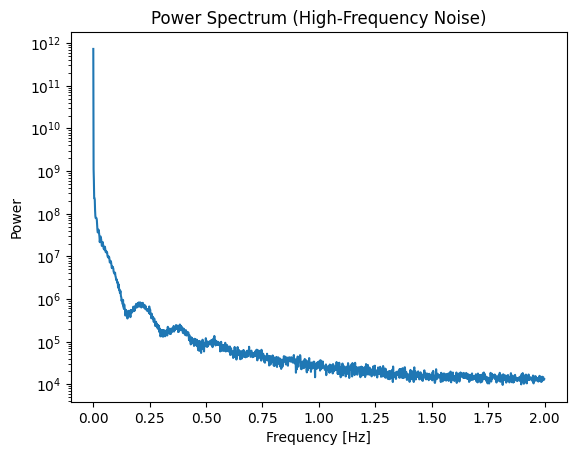

In [513]:
# Define a high-pass filter
series = df_regular["intake_temp_f"]

# Plot the power spectrum focusing on high frequencies
def plot_power_spectrum(series, sampling_frequency_hz):
    # Calculate the FFT of the filtered series
    fft_values = np.fft.fft(series)

    # Compute the power spectrum
    power_spectrum = np.abs(fft_values) ** 2

    # Frequency array
    freq = np.fft.fftfreq(len(series), d=1/sampling_frequency_hz)

    plt.plot(freq[:len(freq)//2], power_spectrum[:len(power_spectrum)//2])  # Plot only positive frequencies
    #plt.xlim([cutoff_freq, fs / 2])  # Limit x-axis to high frequencies
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.yscale('log')
    plt.title('Power Spectrum (High-Frequency Noise)')
plot_power_spectrum(series, sampling_frequency_hz)


Signal starts to become apparent below 0.25 and 0.50 Hz.  So we'll run a high pass filter on these ranges and replot the power spectrum.

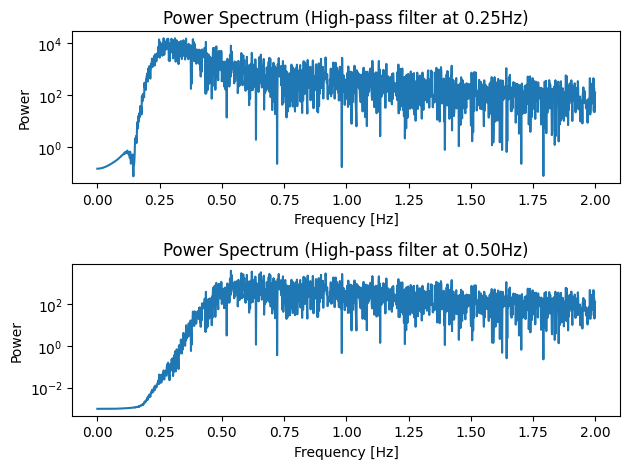

In [514]:
def high_pass_filter(data, cutoff_freq, fs, order=5):
    """high-pass filter to remove low-frequency components"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y


cutoff_freqs = [0.25, 0.5]
for i, cutoff_freq in enumerate(cutoff_freqs):
    plt.subplot(2,1,i+1)
    filtered_signal = high_pass_filter(series, cutoff_freq, sampling_frequency_hz)
    plot_power_spectrum(filtered_signal, sampling_frequency_hz)
    plt.title(f"Power Spectrum (High-pass filter at {cutoff_freq:0.2f}Hz)")
plt.tight_layout()


I'm looking for the lowest frequency at which I could expect the temperature to be mostly noise.  To my eye it's definitely closer to 0.5 than 0.25.  So, we'll go with a low-pass filter of 0.5 and see what the filtered signal looks like. 

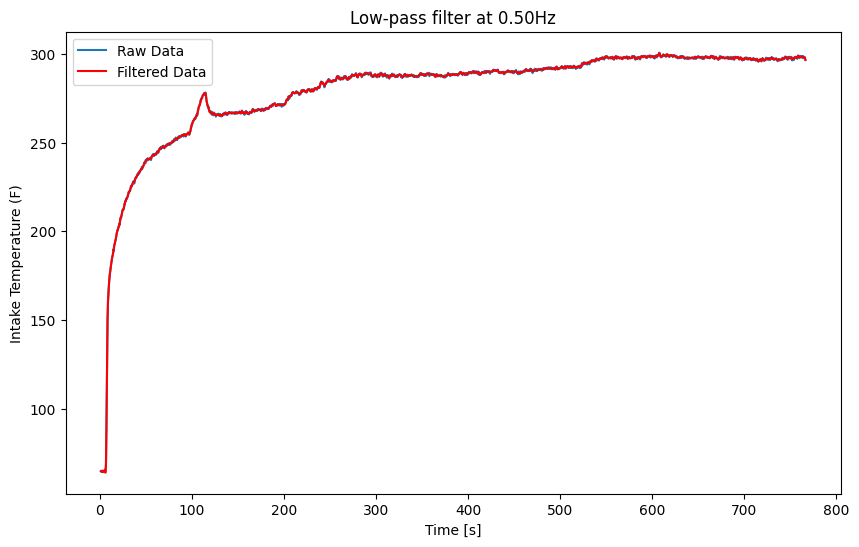

In [515]:
# Define a low-pass filter
def low_pass_filter(data, cutoff_freq, fs=sampling_frequency_hz, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the low-pass filter
cutoff_freq = 0.5
filtered_signal = low_pass_filter(series, cutoff_freq)

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(df_regular['total_time'], series, label='Raw Data')
plt.plot(df_regular['total_time'], filtered_signal, label='Filtered Data', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Intake Temperature (F)')
plt.title(f'Low-pass filter at {cutoff_freq:0.2f}Hz')
plt.legend()
plt.show()


Noise is clearly increasing with temperature at later times  possibly because the influence of the beans.  And, it is lower frequency noise.  This suggests that at the end of the day a Kalman Filter or Gaussian Process will do a better job fitting the data rather than a simple band filter.  I will work on that later.  For now plot both bean and intake as filtered data.  

In the end, I just filtered the bean temperature until it was monotonically increasing while the beans were roasting.  That came out to a low-pass filter of 0.01Hz which is pretty long.

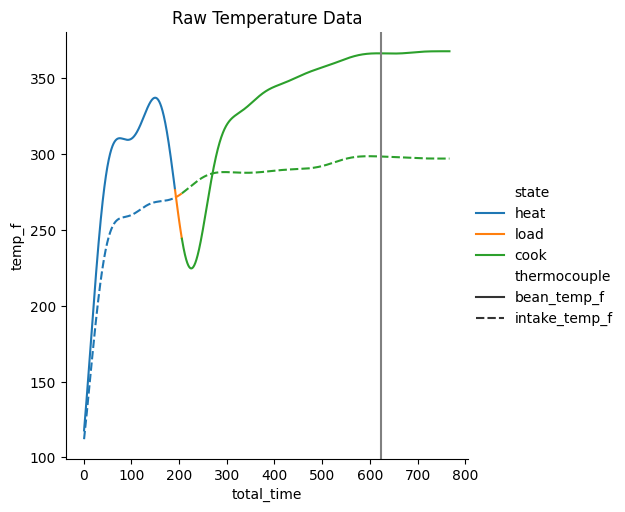

In [516]:
cutoff_freq = 0.01
df_filter = df_regular.copy()
df_filter['intake_temp_f'] = low_pass_filter(df_regular['intake_temp_f'],cutoff_freq)
df_filter['bean_temp_f'] = low_pass_filter(df_regular['bean_temp_f'],cutoff_freq)
plot_roast_profile(df_filter)

## Calibration

### Offsets
I heard the first crack a 429 seconds into the roast (I believe).  That was 21.7 degrees lower than the final roast temperature.  I don't remember exactly the weight loss but it was over 15%.  This would put us clearly in French roast territory.  If first crack happens at 405F and I stopped at 448F, that's a pretty wide gap.

In [533]:
index = bisect.bisect_left(df_filter['total_time'],7*60+9)
first_crack_bean_temp = df_filter.loc[index, 'bean_temp_f']
max_bean_temp = max(df_filter['bean_temp_f'])

print(f"First Crack Roast Time Measured: {df_filter.loc[index,'roast_time']:0.0f}s")
print(f"First Crack Bean Temp Measured: {first_crack_bean_temp:3.1f}F")
print(f"Max Bean Temp Measured: {max_bean_temp:3.1f}F")

First Crack Roast Time Measured: 223s
First Crack Bean Temp Measured: 348.1F
Max Bean Temp Measured: 367.8F


The thermocouples read high relative to ambient temperature when i was installing them.  This suggests that i need both offset and gain correction.  If $y$ is the actual temperature and $x$ is the read temperature, then I have a simple linear model.
$ y = ax + b $  where $a$ is the gain and $b$ is the offset.

I can measure this, but my best guess is that the offset is around 9 degrees at room temperature.  To calculate gain.  I've got three points.  350 measured at 405 truth.  And let's call it 70F measured and 68F actual for room temperature.  Finally the max temperature was likely 448F truth and 370.9 measured 

In [535]:
gain = (405-70) / (348.1-67)
offset = 405 - gain * 349.2

corrected_max_bean_temp = gain * max_bean_temp + offset

print(f"Offset: {offset:3.1f}F")
print(f"Gain: {gain:3.1f}")
print(f"Raw Max: {max_bean_temp:3.1f}F")
print(f"Corrected Max: {corrected_max_bean_temp:3.1f}F")



Offset: -11.2F
Gain: 1.2
Raw Max: 367.8F
Corrected Max: 427.2F


Since we have 3 reference points, we can also fit a quadratic.

In [ ]:
T_real = np.array([65, 405, 448])  # Known real temperatures (°C)
T_raw = np.array([70, 349.2, 370.9])    # MAX6675 readings (°C)

coeffs = np.polyfit(T_raw, T_real, 2)  # Returns [a, b, c]

print(f"a = {coeffs[0]:0.4f}, b = {coeffs[1]:0.4f}, c = {coeffs[2]:2.4f}")
  

a = 0.0025, b = 0.1537, c = 41.8049


Applying the low-pass filter and the quadratic to all the data.  We remove the edges of the data where the filter breaks down. 

In [ ]:
df_subset["temp_corrected_f"] = np.polyval(coeffs, 
df_subset  = df_melted[(df_melted["total_time"]>5) & (df_melted["total_time"]<750)]
city_roast_temp = 425
sns.relplot(data=df_subset, x="total_time", y="temp_corrected_f", hue="state", style="thermocouple", kind="line")
plt.axvline(x=7*60+9, color='gray')
plt.axhline(y=city_roast_temp)
plt.show()

ValueError: Could not interpret value `temp_corrected_f` for `y`. An entry with this name does not appear in `data`.

### First Crack estimates

You can also estimate the first crack by graphing the first derivative of bean temperature

In [521]:
value = df_filter['bean_temp_f'].diff()  # Using diff() to calculate the difference
dt = df_filter['total_time'].diff()  # Using diff() to calculate the time difference
df_filter['bean_temp_slope'] = value / dt

value = df_filter['intake_temp_f'].diff()  # Using diff() to calculate the difference
dt = df_filter['total_time'].diff()  # Using diff() to calculate the time difference
df_filter['intake_temp_slope'] = value / dt

melted_corrected = df_filter.melt(id_vars=['total_time','state'], value_vars=['bean_temp_f', 'intake_temp_f'], var_name='thermocouple', value_name='temp_corrected')
melted_slope = df_filter.melt(id_vars=['total_time','state'], value_vars=['bean_temp_slope', 'intake_temp_slope'], var_name='thermocouple', value_name='slope')

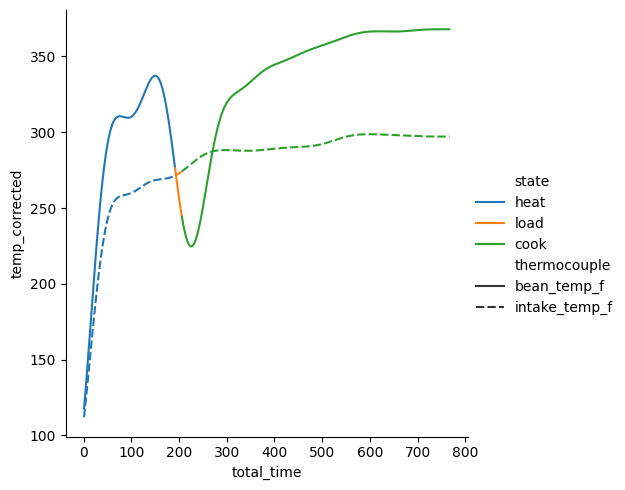

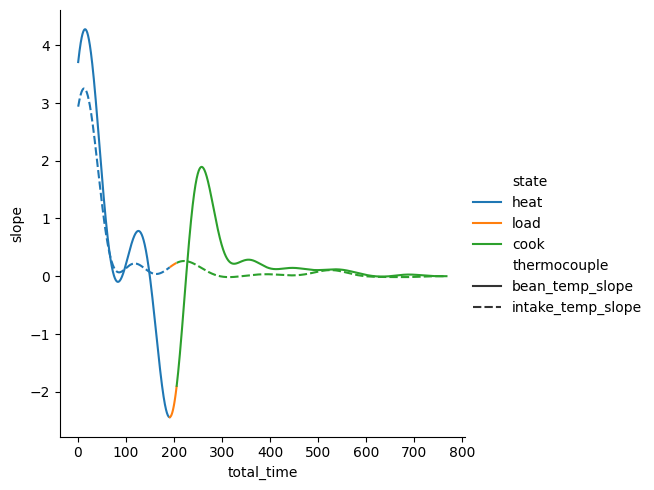

In [522]:
# Create a Seaborn plot with the primary y-axis
sns.relplot(data=melted_corrected, x="total_time", y="temp_corrected", hue="state", style="thermocouple", kind="line")
sns.relplot(data=melted_slope, x="total_time", y="slope", hue="state", style="thermocouple", kind="line")

This graph suggests that first crack happened within about 90 seconds of the roast start.  I can find it exactly.

In [528]:
i_peak, v_peak = find_peaks(df_filter['bean_temp_slope'], height=1.5)
roast_time_first_crack = df_filter.loc[i_peak[-1],'roast_time']
print(f"Roast Time to first crack: {roast_time_first_crack:0.0f} seconds")
print(f"Bean Temp Measured at first crack {df_filter.loc[i_peak[-1],'bean_temp_f']:0.1f}")

Roast Time to first crack: 52 seconds
Bean Temp Measured at first crack 264.6


# Future roasts

Here's what co-pilot said about roasts

The optimal temperature for preheating your roaster before adding the beans depends on the type of roast you aim to achieve. Here are some general guidelines:

### Light Roast
- **Preheat Temperature**: Around 375°F (190°C)
- **First Crack**: Typically occurs between 380-390°F (193-199°C)
- **Finish Temperature**: Before 400°F (204°C)

### Medium Roast
- **Preheat Temperature**: Around 380°F (193°C)
- **First Crack**: Maintain 385-400°F (196-204°C)
- **Finish Temperature**: Extend development time to around 2 minutes after the first crack

### Dark Roast
- **Preheat Temperature**: Around 385°F (196°C)
- **First Crack**: Push through first crack above 400°F (204°C)
- **Finish Temperature**: Maintain until 412°F (211°C) for bold flavors

### General Tips
- **Rate of Rise (RoR)**: Keep RoR at 10°C/min pre-crack, reducing to 5°C/min during development.
- **Chamber Temperature**: Maintain chamber temperature 20-30°F above bean mass temperature throughout the roast.

By preheating your roaster to the appropriate temperature, you can ensure a more controlled and consistent roast, enhancing the flavor profile of your coffee.

Some of this result I believe and some of it I don't.  I don't know that the chamber temperature needs to be 20-30degrees above the mass temperature.
But for the next roast.  I will apply a .75Hz low-pass filter to the temperatures and I will get the heat up to 375